In [437]:
import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

np.set_printoptions(suppress=True) # Suppress scientific notation where possible
pd.set_option('display.max_rows', 70)


In [438]:
# read in pickled data
X_train, X_test = pd.read_pickle('pickle/xtrain.pkl'), pd.read_pickle('pickle/xtest.pkl')
y_train, y_test = pd.read_pickle('pickle/ytrain.pkl'), pd.read_pickle('pickle/ytest.pkl')

X_train_scaled, X_test_scaled = pd.read_pickle('pickle/xtrain_scaled.pkl'), pd.read_pickle('pickle/xtest_scaled.pkl')
y_train_scaled = y_train

In [439]:
include_in_model = ['X56','X55','X40','X27','X13','X26','X39','X16','X34','X35','X41','X46','X21','X38']
#                  ['X39','X21','X29','X35','X27','X22','X6','X46','X45','X34','X14','X38','X57','X11']
X_train = X_train[include_in_model]
X_test = X_test[include_in_model]
X_train_scaled = X_train_scaled[include_in_model]
X_test_scaled = X_test_scaled[include_in_model]

In [440]:
data = X_train.append(X_test)

In [441]:
# addressing imbalance in the target variable
# X_train, y_train = SMOTE(random_state=42).fit_sample(X_train,y_train)
# X_train_scaled, y_train_scaled = SMOTE(random_state=42).fit_sample(X_train_scaled,y_train_scaled)

In [442]:
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rf_params = {'n_estimators': [300,400,500,600]
            , 'max_features': ['auto', 'sqrt', 'log2']
            , 'max_depth': [20,30,40,50]
            , 'criterion':['gini', 'entropy']}
xg_params = {'colsample_bytree': [0.5,0.6,0.8,1]
             , 'learning_rate': [0.2,0.3,0.4]
             , 'max_depth': [3,4,5,6,7]
             , 'alpha': [0,0.08,0.01]
             , 'gamma': [0,0.004,0.008,0.01]}

# initialize various classification models
# employ gridsearchcv in tuning parameters
knn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(solver='lbfgs',max_iter=8000,C=1000)
# lr = GridSearchCV(LogisticRegression(solver='lbfgs',max_iter=6000), lr_params, cv=5)
nb = GaussianNB()
sv = svm.SVC(probability=True)
dt = DecisionTreeClassifier()
# rf = GridSearchCV(RandomForestClassifier(random_state=42,n_jobs=-1), rf_params, cv=5, n_jobs=-1)
rf = RandomForestClassifier(random_state=42,n_jobs=-1,criterion='entropy',max_depth=30,max_features='auto'
                            ,n_estimators=700)
xg = XGBClassifier(alpha=0,colsample_bytree=0.5,gamma=0.01,learning_rate=0.3,max_depth=6)
# xg = XGBClassifier(alpha=0,colsample_bytree=0.5,gamma=0.01,learning_rate=0.3,max_depth=6)
# xg = GridSearchCV(XGBClassifier(), param_grid=xg_params, n_jobs=-1, cv=5)

models = [knn, lr, nb, sv, dt, rf, xg]
model_desc = ['KNN', 'Logistic Regression', 'Naive Bayes', 'SVM', 'Decision Trees', 'Random Forest','XG Boost']
# models = [rf,xg]
# model_desc = ['Random Forest','XG Boost']

In [443]:
# store model results in dataframe
df_results = pd.DataFrame(columns=['Model','Precision','Recall','F1_CV','F1','AUC','Log Loss'])

In [444]:
model_confusions = []
model_positives = []
feature_importance_rf = []
feature_importance_xg = []

for index, model in enumerate(models):
    print(f'>>>>>>>>>>>> Running {model_desc[index]}')
    
    # KNN will use the scaled dataset, while the others will use the unscaled one
    X_train = (X_train_scaled if model_desc[index] == 'KNN' else X_train)
    X_test = (X_test_scaled if model_desc[index] == 'KNN' else X_test)
    y_train = (y_train_scaled if model_desc[index] == 'KNN' else y_train)

#     if model_desc[index] == 'XG Boost':
#         X_test = X_test.values
    
    # get f1 score on training set
    f1_cv = np.mean(cross_val_score(model, X_train, y_train.values.ravel(), cv=10, scoring='f1'))
    
    # fit model
    model.fit(X_train, y_train.values.ravel())
    
    if model_desc[index] == 'Random Forest':
        feature_importance_rf = model.feature_importances_
    if model_desc[index] == 'XG Boost':
        feature_importance_xg = model.feature_importances_
    
    # predict
    model_predictions = model.predict(X_test)
    #for threshold in np.arange(0.1,1.0,0.1):
    #    model_predictions = (model_probabilities[:,1] >= threshold).astype('int')
    model_probabilities = model.predict_proba(X_test)

    model_confusions.append(confusion_matrix(y_test, model_predictions))
    model_positives.append(roc_curve(y_test, model_probabilities[:,1]))
    fpr, tpr, thresholds = roc_curve(y_test, model_probabilities[:,1])
    
#     print(f'Best parameters: {model.best_params_}')
    
    df_results.loc[len(df_results)] = [model_desc[index]
                                      , precision_score(y_test, model_predictions)
                                      , recall_score(y_test, model_predictions)
                                      , f1_cv
                                      , f1_score(y_test, model_predictions)
                                      , roc_auc_score(y_test, model_probabilities[:,1])
                                      , log_loss(y_test, model_probabilities)]

df_results

>>>>>>>>>>>> Running KNN
>>>>>>>>>>>> Running Logistic Regression
>>>>>>>>>>>> Running Naive Bayes
>>>>>>>>>>>> Running SVM


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 

>>>>>>>>>>>> Running Decision Trees
>>>>>>>>>>>> Running Random Forest
>>>>>>>>>>>> Running XG Boost


,Model,Precision,Recall,F1_CV,F1,AUC,Log Loss
0,KNN,0.380952,0.090909,0.134941,0.146789,0.655326,1.473412
1,Logistic Regression,0.428571,0.034091,0.100051,0.063158,0.825640,0.286630
2,Naive Bayes,0.074653,0.977273,0.119981,0.138710,0.525127,6.189614
3,SVM,0.000000,0.000000,0.011775,0.000000,0.613699,0.266014
4,Decision Trees,0.619718,0.500000,0.560542,0.553459,0.737660,2.074664
5,Random Forest,0.847826,0.443182,0.611160,0.582090,0.922018,0.145461
6,XG Boost,0.779661,0.522727,0.669825,0.625850,0.931226,0.174361


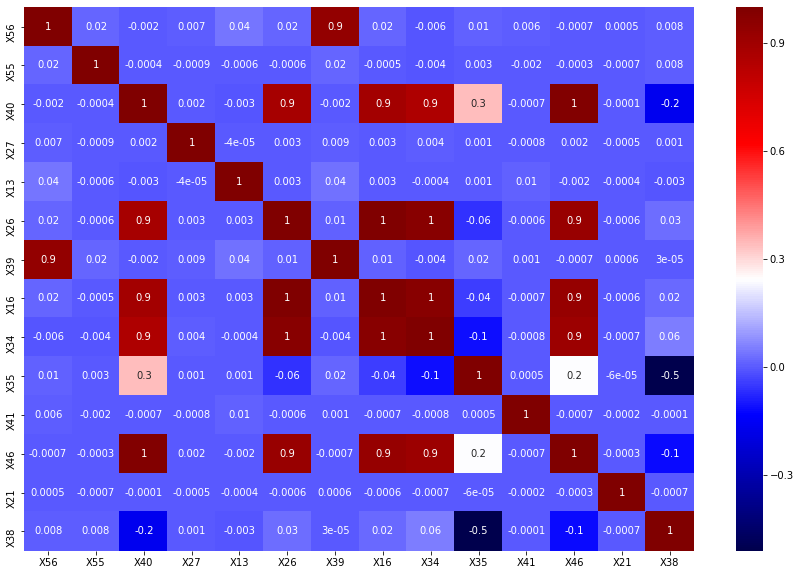

In [445]:
plt.figure(figsize=(15,10))
sns.heatmap(data[include_in_model].corr(),cmap='seismic',annot=True,fmt='.1g')

In [446]:
# exclude_from_model = ['']

In [447]:
# lr.coef_

In [448]:
# feature_importance_rf
features_rf = pd.DataFrame(feature_importance_rf,index=X_train.columns
             , columns=['importance']).sort_values('importance',ascending=False).reset_index().head(20)

# feature_importance_xg
features_xg = pd.DataFrame(feature_importance_xg,index=X_train.columns
             , columns=['importance']).sort_values('importance',ascending=False).reset_index().head(20)

In [449]:
list(set(features_rf.iloc[:,0]) & set(features_xg.iloc[:,0]))

['X56',
 'X40',
 'X55',
 'X27',
 'X13',
 'X26',
 'X39',
 'X16',
 'X34',
 'X35',
 'X41',
 'X38',
 'X46',
 'X21']

In [450]:
features_xg

,index,importance
0,X21,0.135859
1,X35,0.113583
2,X34,0.094621
3,X27,0.092758
4,X41,0.089286
5,X39,0.066126
6,X56,0.064613
7,X46,0.063364
8,X55,0.058673
9,X13,0.051255
